# Необходимые импорты

In [1]:
import pandas as pd

#линейная регрессия, ridge, lasso
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

#рандомное разделение данных на тестовые и тренировочные
from sklearn.model_selection import train_test_split

#Метод случайного леса
from sklearn.ensemble import RandomForestRegressor

#Gradient Boosting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#поиск параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#нормализация данных
from sklearn.preprocessing import StandardScaler

import numpy as np

#оценки качества модели
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

#визуализация
import matplotlib.pyplot as plt

#сид для random_state
SEED = 13

# Подготовка данных

In [2]:
df = pd.read_csv("data/laptop_prices.csv")
print(f"Количество элементов в датафрейме: {df.size}")
print(f"Форма датафрейма: {df.shape}")
df.info()
df.nunique()

Количество элементов в датафрейме: 29325
Форма датафрейма: (1275, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CP

Company                  19
Product                 618
TypeName                  6
Inches                   18
Ram                       9
OS                        9
Weight                  171
Price_euros             791
Screen                    4
ScreenW                  13
ScreenH                  10
Touchscreen               2
IPSpanel                  2
RetinaDisplay             2
CPU_company               3
CPU_freq                 25
CPU_model                93
PrimaryStorage           13
SecondaryStorage          6
PrimaryStorageType        4
SecondaryStorageType      4
GPU_company               4
GPU_model               110
dtype: int64

In [3]:
df[['IPSpanel', 'Touchscreen', 'RetinaDisplay']].head()

,IPSpanel,Touchscreen,RetinaDisplay
0,Yes,No,Yes
1,No,No,No
2,No,No,No
3,Yes,No,Yes
4,Yes,No,Yes


In [4]:
#преобразуем object в category для уменьшения размера датафрейма

category_cols = ["TypeName", "OS", "Screen", "CPU_company", "PrimaryStorageType", "SecondaryStorageType", "GPU_company"]

for col in category_cols:
    df[col] = df[col].astype('category')
    
#также, везде, где есть два значения (yes/no), можно преобразовать в булевые столбцы
yes_no_cols =  ['Touchscreen', 'IPSpanel', 'RetinaDisplay']

for col in yes_no_cols:
    df[col] = df[col].map({"Yes" : True, "No" : False}).astype(bool)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Company               1275 non-null   object  
 1   Product               1275 non-null   object  
 2   TypeName              1275 non-null   category
 3   Inches                1275 non-null   float64 
 4   Ram                   1275 non-null   int64   
 5   OS                    1275 non-null   category
 6   Weight                1275 non-null   float64 
 7   Price_euros           1275 non-null   float64 
 8   Screen                1275 non-null   category
 9   ScreenW               1275 non-null   int64   
 10  ScreenH               1275 non-null   int64   
 11  Touchscreen           1275 non-null   bool    
 12  IPSpanel              1275 non-null   bool    
 13  RetinaDisplay         1275 non-null   bool    
 14  CPU_company           1275 non-null   category
 15  CPU_

# Общая функция для работы с разными моделями регрессий

Алгоритм будет передаваться внутрь функции в качестве аргумента.
Цена ноутбука будет предсказываться по нескольким признакам: **объём оперативной памяти, ширина и высота экрана, объём первого и второго хранилищ, диагональ экрана, вес**

Также в функцию передаём цвет и тип линии, чтобы графики получались разные


In [5]:
x = df[['Ram', "ScreenW", "ScreenH", "PrimaryStorage", "SecondaryStorage", "CPU_freq", "Inches", "Weight"]]
y = df['Price_euros']

def data_split(x = x, y = y):
    #разделение на тренировочные и тестовые данные
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size= 0.2, random_state = SEED)
    return train_x, test_x, train_y, test_y

def model_predict(model, model_name, 
                        color, line_type, 
                        x = x, y = y):
    
    train_x, test_x, train_y, test_y = data_split(x,y)
    #обучение
    model.fit(train_x, train_y)
    predict_y = model.predict(test_x)

    #оценки качества модели
    mae = mean_absolute_error(test_y, predict_y)
    mse = mean_squared_error(test_y, predict_y)
    rmse = root_mean_squared_error(test_y, predict_y)
    r2 =  r2_score(test_y, predict_y)

    print(f"Модель: {model_name}")
    print("-------------------")
    print(f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE:{rmse:.2f}\nR2:{r2:.2f}\nРазница между RMSE и MAE: {(rmse - mae):.2f}")
    
    #также добавим сразу визуализацию в функцию
    plt.figure(figsize=(8, 6))
    plt.scatter(test_y, predict_y, alpha=0.5, c = color)
    plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], line_type)
    plt.xlabel("Реальные значения")
    plt.ylabel("Предсказанные значения")
    plt.title(f"{model_name}: реальные цены против предсказанных")    
    plt.grid(True)
    
    #сохранение графика модели
    filename = model_name.replace(" ", "_") + ".png" #заменяем навзвание с пробелами на нижние подчёркивания
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

# Линейная регрессия

Модель: Линейная регрессия
-------------------
MAE: 313.05
MSE: 210652.47
RMSE:458.97
R2:0.63
Разница между RMSE и MAE: 145.92


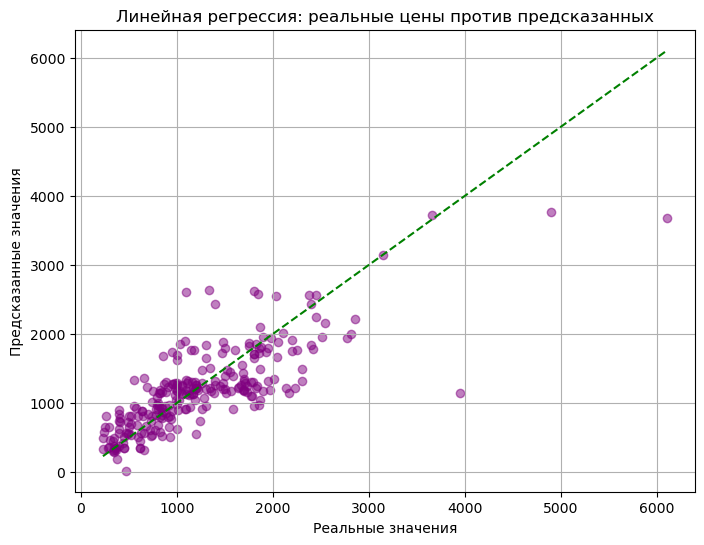

In [6]:
linear_regression = LinearRegression()

model_predict(linear_regression, "Линейная регрессия", 'purple', 'g--')

### По оценкам метрик можно сделать следующие выводы:

- MAE (средняя абсолютная ошибка) : в целом, модель ошибается на примерно 313 евро
- MSE (средняя квадратичная ошибка): учитывается квадрат ошибок, из-за чего чувствительность к ошибам выше
- RMSE (корень из средней квадратической ошибки): корень из MSE, следовательно резульат в евро. Можно увидеть, что RMSE > MAE на 145.92 евро, что означает наличие нескольких крупных ошибок, которые совершает модель.
- R2 : означает, что модель работает относительно неплохо, 63% дисперсий в данных объяснены. Оставшиеся 37% могут быть шумом, недостатком данных, и т.д

## Ridge / Lasso регрессии

Это два регуляционных метода для линейной регрессии для борьбы с переобучением модели.

Идёт выбор нескольких альфа, из которых RidgeCV и LassoCV выберут самый подходящий вариант из списка с помощью кросс-валидации. Число фолдов кросс-валидации: 5

In [7]:
alphas = [0.1, 0.5, 1.0, 1.5, 2, 2.5, 0.05, 0.01, 0.15, 2.25]

Модель: Ridge
-------------------
MAE: 312.92
MSE: 210608.27
RMSE:458.92
R2:0.63
Разница между RMSE и MAE: 146.00


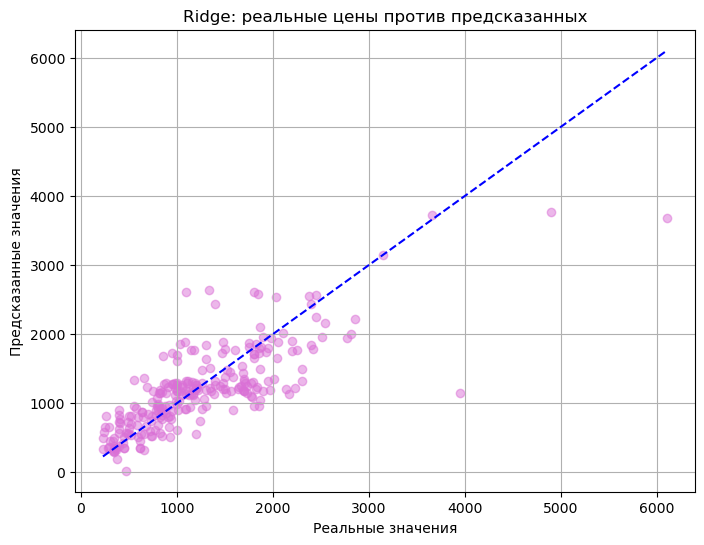

In [8]:
ridge_cv = RidgeCV(alphas = alphas, cv = 5)

model_predict(ridge_cv, "Ridge", 'orchid', 'b--')

Модель: Lasso
-------------------
MAE: 313.05
MSE: 210650.74
RMSE:458.97
R2:0.63
Разница между RMSE и MAE: 145.92


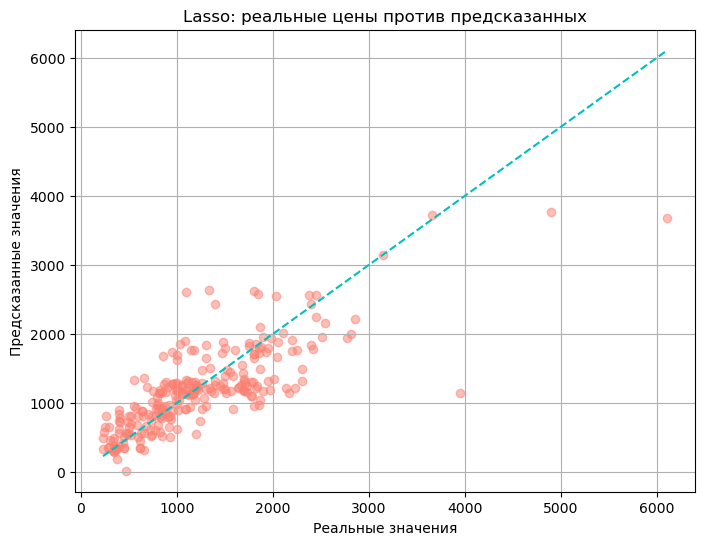

In [9]:
lasso_cv = LassoCV(alphas = alphas, cv = 5)

model_predict(lasso_cv, "Lasso", 'salmon', 'c--')

## Elastic-Net

Это дополнительный метод регуляции линейной регресии, который является компромисным вариантом между Lasso и Ridge.

/home/faust/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.399e+06, tolerance: 4.776e+04
  model = cd_fast.enet_coordinate_descent(


Модель: Elastic Net
-------------------
MAE: 312.79
MSE: 210570.25
RMSE:458.88
R2:0.63
Разница между RMSE и MAE: 146.09


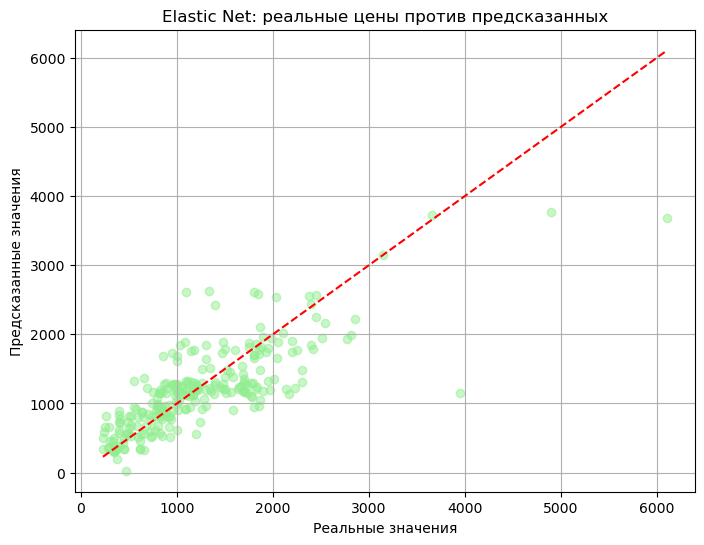

In [10]:
elastic_net_cv = ElasticNetCV(alphas = alphas, cv = 5)

model_predict(elastic_net_cv, "Elastic Net", 'lightgreen', 'r--')

## После применения LassoCV, RidgeCV и ElasticNetCV ожидалось то, что результаты будут сильнее отличаться от линейной регрессии, так как разницы также не было при использовании обычных Lasso, Ridge и Elastic Net

Модели, судя по всему, совершают схожие ошибки

#### Какие возможные причины:
 - Признаки могут быть мало связаны с целевой переменной или сильно кореллированы
 - Датасет, возможно, слишком простой для методов регуляции
 - Нет нелинейности

Для дальнейшего анализа следует попробовать больше моделей. Возможно, есть зависимости, которые модели выше уловить не могут

# Random Forest Regressor

Модель: Random Forest Regressor
-------------------
MAE: 236.45
MSE: 129737.56
RMSE:360.19
R2:0.77
Разница между RMSE и MAE: 123.74


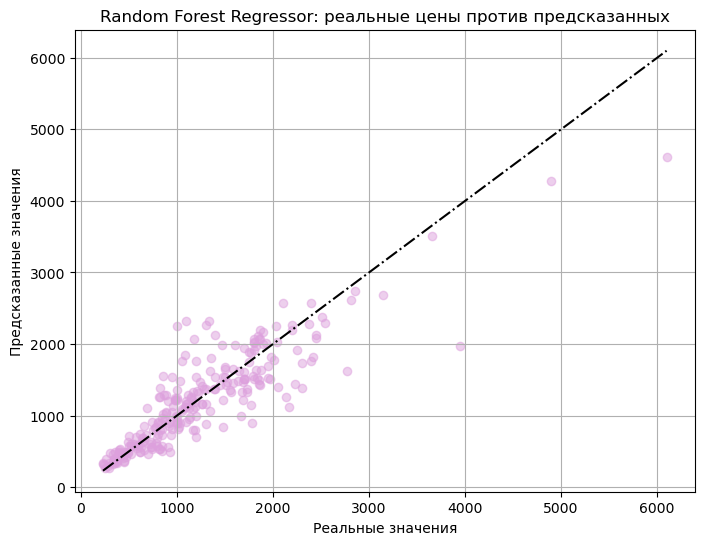

In [11]:
rfr = RandomForestRegressor()

model_predict(rfr, "Random Forest Regressor", 'plum', 'k-.')

###  Выводы: 
- Значения MAE, MSE, RMSE заметно снизились, а следовательно -- разница между RMSE и MAE. 
- R2 = ~0.77, качество модели выросло и объясняется ~77% дисперсий, что хорошо, в сравнении с прошлыми моделями
- Разница RMSE и MAE стала меньше, модель деляет чуть менее серьёзные ошибки.

#### Значит, RMR лучше объясняет нелинейные зависимости

Также, с помощью RMR можно узнать, какие признаки больше всего влияют на предсказание цены

In [12]:
features = ['Ram', "ScreenW", "ScreenH", "PrimaryStorage", "SecondaryStorage", "CPU_freq", "Inches", "Weight"]

features_df = pd.DataFrame({'feature': features,
                           'importance' : rfr.feature_importances_})

features_df = features_df.sort_values(by="importance", ascending = False)
features_df

,feature,importance
0,Ram,0.581100
7,Weight,0.163188
5,CPU_freq,0.103545
3,PrimaryStorage,0.051531
1,ScreenW,0.033262
6,Inches,0.029843
2,ScreenH,0.023982
4,SecondaryStorage,0.013550


Больше всего на цену из всех использованых признаков влияет количество оперативной памяти. Меньше всего влияет размер вторичного хранилища, возможно, потому что часто его нет.

# Gradient Boosting (XGBoost, LightGBM)

In [13]:
#поиск параметров XGBoost
def find_xgboost(x, y):
    model = XGBRegressor(tree_method='hist', device ='gpu')  #использование гистограмм для ускорения
    params = {'n_estimators': [500, 700, 1000], #количество деревьев
              'max_depth': [3, 5, 7], #максимальная глубина деревьев
              'learning_rate': [0.01], #скорость обучения
              'subsample': [0.8, 1.0] #доля случайных строк для каждого дерева
             }
    
    
    search = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    search.fit(x, y)
    return search.best_params_

train_x, text_x, train_y, text_y = data_split()

best_xgb_params = find_xgboost(train_x, train_y)
print("Самые подходящие параметры для XGBoost:", best_xgb_params)

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [1

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: User

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/skl

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/skl

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Самые подходящие параметры для XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Вывод: **Самые подходящие параметры для XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}**

In [14]:
#поиск параметров для LightGBM

def find_lightgbm(x, y):
    model = LGBMRegressor(verbose = -1, boosting_type = 'gbdt')  #скрываем логи
    params = {'n_estimators': [500, 700, 1000],
              'learning_rate': [0.01, 0.05],
              'subsample': [0.8, 1.0],
              'num_leaves': [63, 127],  #максимальное число листьев в дереве
              'min_child_samples' : [10, 20] #защита от переобучения
             }
    
    search = RandomizedSearchCV(model, params, 
                                n_iter = 10, #количество итераций 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                n_jobs= 1)
    search.fit(x, y)
    return search.best_params_

best_lgbm_params = find_lightgbm(train_x, train_y)
print("Самые подходящие параметры для LightGBM:", best_lgbm_params)

Самые подходящие параметры для LightGBM: {'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 10, 'learning_rate': 0.01}


Модель: XGBoost
-------------------
MAE: 241.76
MSE: 140903.40
RMSE:375.37
R2:0.75
Разница между RMSE и MAE: 133.62


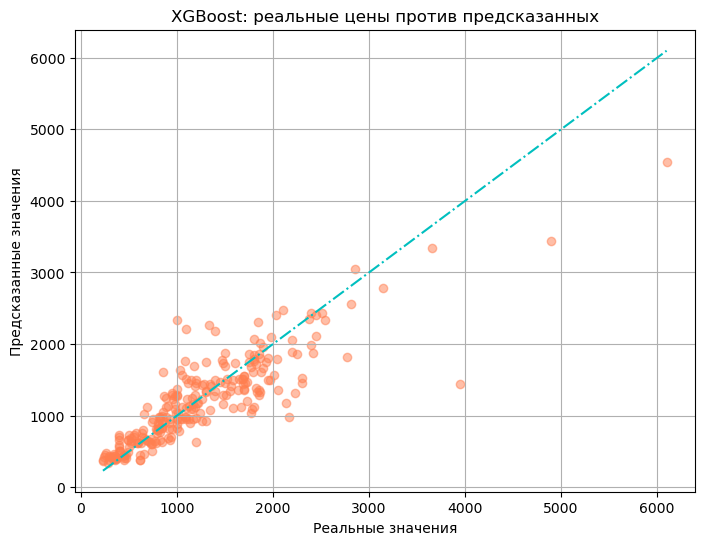

In [15]:
xgb = XGBRegressor(learning_rate = 0.01, max_depth = 3, n_estimators = 500, subsample = 0.8)

model_predict(xgb, "XGBoost", 'coral', 'c-.')

Модель: LightGBM
-------------------
MAE: 241.76
MSE: 140903.40
RMSE:375.37
R2:0.75
Разница между RMSE и MAE: 133.62


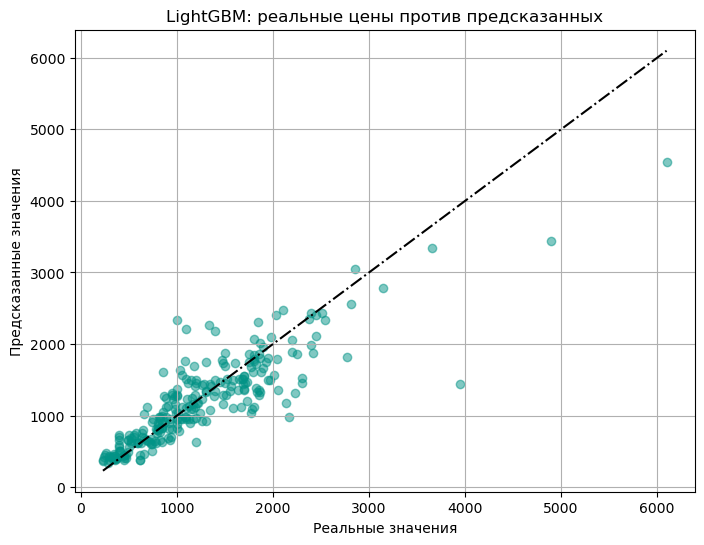

In [16]:
lgbm = LGBMRegressor(learning_rate = 0.01, n_estimators = 500, subsample = 1, num_leaves = 127,
                    reg_alpha = 0.1, #l1 регуляция
                    reg_lambda = 0.1, #l2 регуляция)
                    min_child_samples = 10,
                    boosting_type = 'gbdt')

model_predict(xgb, "LightGBM", 'xkcd:teal', 'k-.')

### Обе модели показали эффективность в 75%, отставая от RandomForest лишь на 2%.

## Финальные выводы:

|Метрика| Линйеная регрессия | Ridge | Lasso | Elastic Net | Random Forest | XGBoost | LightGBM |
|:------:|:------------------|:------|:------|:------------|:--------------|:--------|:---------|
| MAE | 313.05 | 312.92 | 313.05 | 312.79 | 234.55 | 241.76 | 241.76 |
| MSE | 210652.47 | 210608.27 | 210650.74 | 210570.25 | 131352.71 | 140903.40 | 140903.40 |
| RMSE | 458.97 | 458.92 | 458.97 | 458.88 | 362.43 | 375.37 | 375.37 |
| R2 | 0.63 | 0.63 | 0.63 | 0.63 | **0.77** | 0.75 | 0.75 |
| RMSE - MAE | 145.92 | 146.00 | 145.92 | 146.09 | 127.88 | 133.62 | 133.62 |


- Лучшие показатели у Random Forest Regressor, который устойчив к выбросам.
- Не сильно хуже себя показали XGBoost и LightGBM, возможно, их работу можно улучшить с помощью дополнительного переподбора гиперпараметров
- Линейные модели показали себя хуже всего в одинаковой мере. Это значит, что в данных присутствуют нелинейные зависимости
- Везде заметны достаточно большие выбросы, что говорит о наличии больших выбросов типо слишком дорогих или слишком дешёвых ноутбуков и в целом неравномерном распределении ошибок
- В будущем стоит попробовать учитывать ещё и категориальные данные. Может быть, поможет улучшить качество моделей. Стоит, скорее всего, обратить внимание на "GPU_model" и "CPU_model", так как пользователи часто выбирают устройства именно по этим двум пунктам.
- В исходных данных не учитывается сезонность или акции, возможно, есть неучтённые признаки, которые могут влиять на цену (качество веб-камеры, и т.д)
- Сильнее всего на цену влияет количество RAM, меньше всего - размер дополнительного хранилища


# Вывод всех графиков сразу для наглядной демонстрации:

/home/faust/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.399e+06, tolerance: 4.776e+04
  model = cd_fast.enet_coordinate_descent(


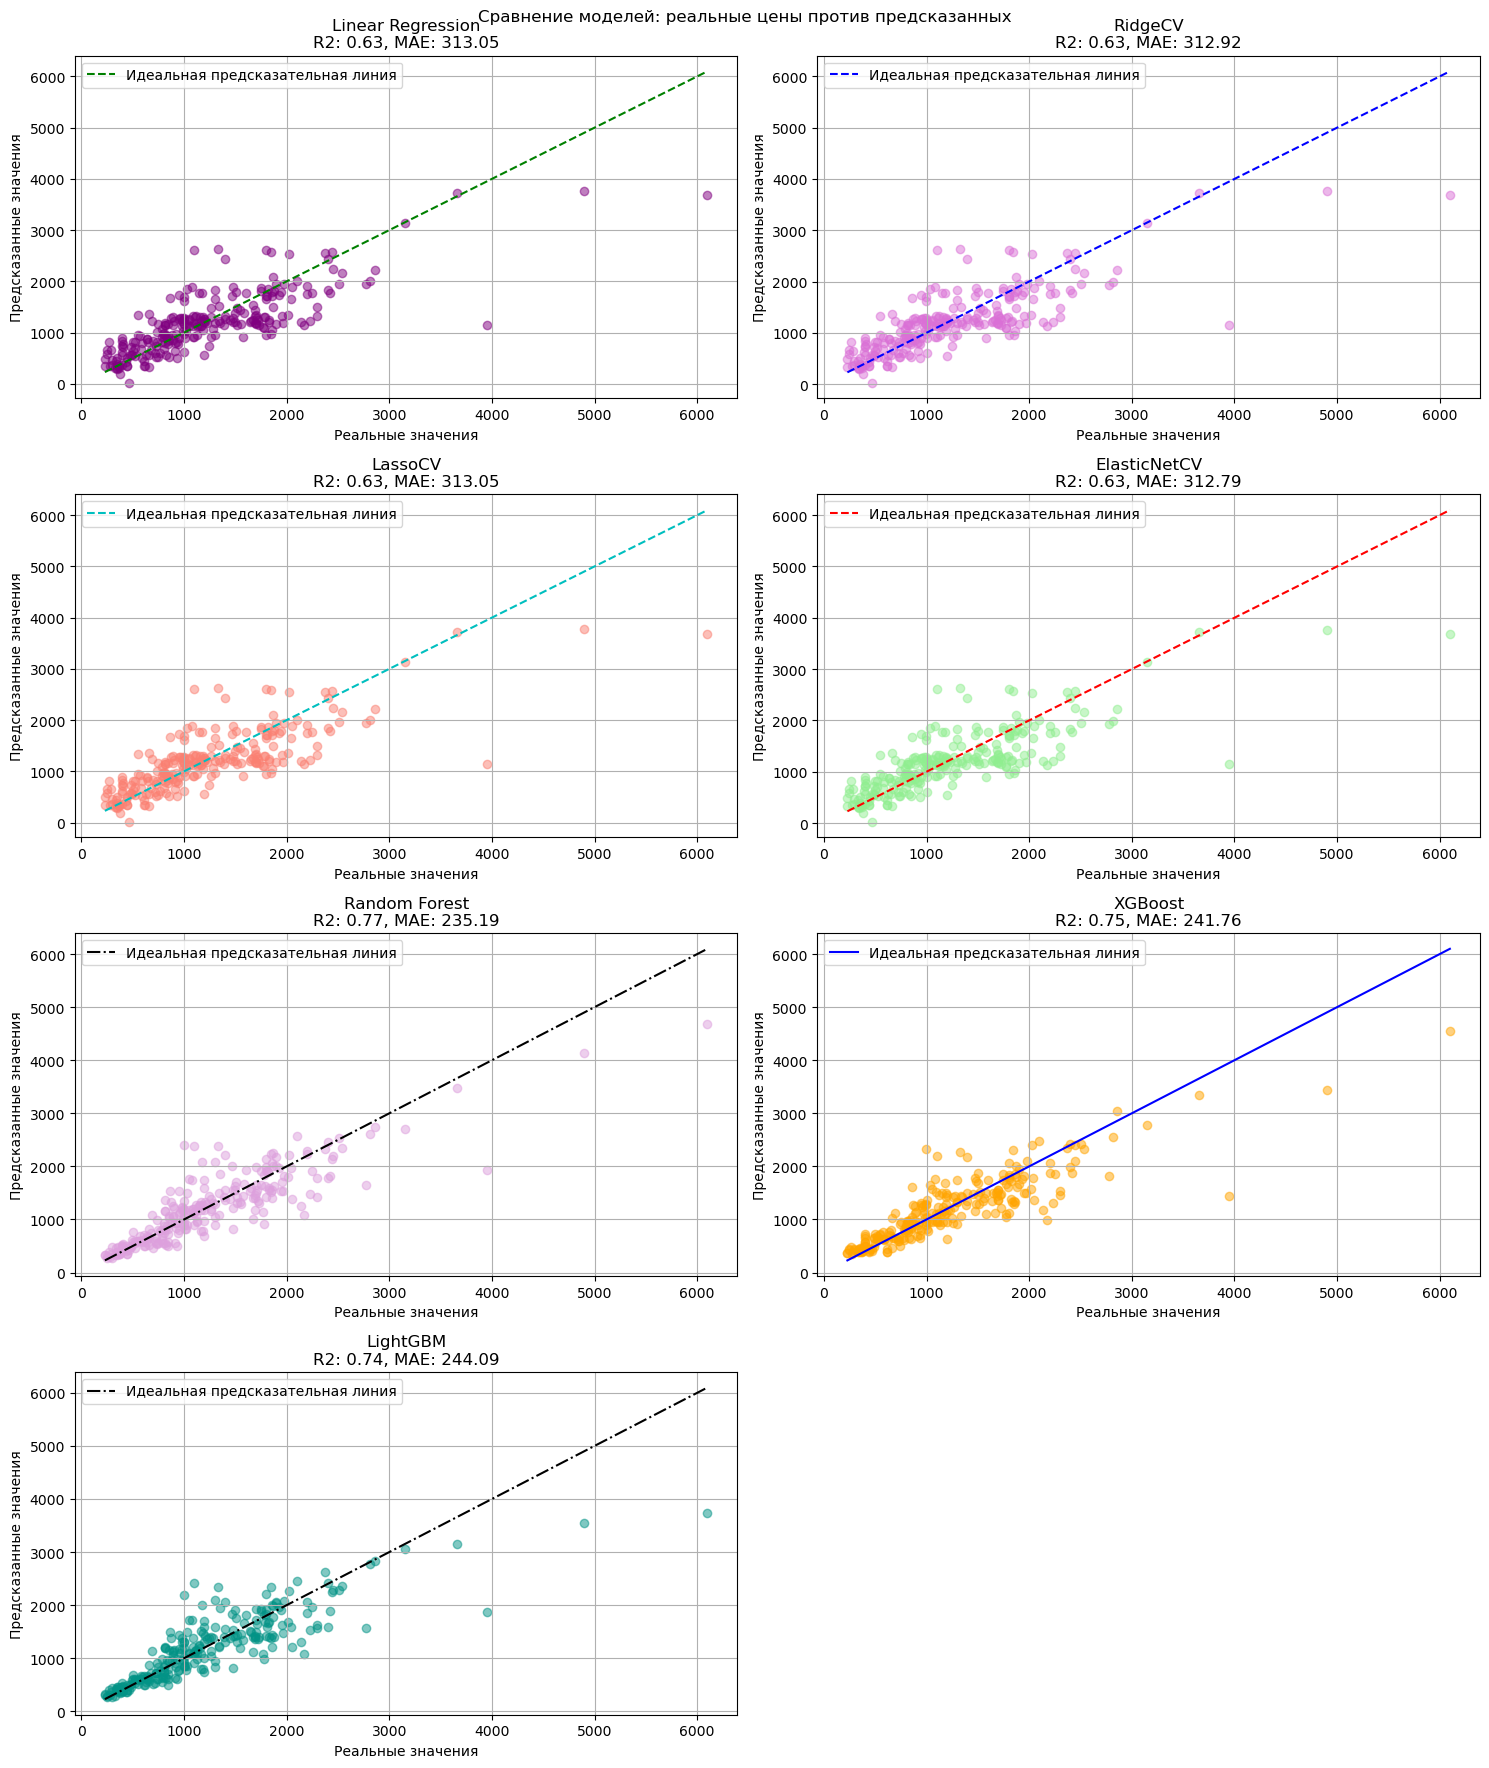

In [24]:
def model_visualize_all(models_dict, x=x, y=y, figsize=(15, 18)):
    
    n_models = len(models_dict)
    n_cols = 2  #столбцы
    n_rows = (n_models + 1) // n_cols  #строки
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Сравнение моделей: реальные цены против предсказанных', fontsize=12)
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)  #если строка одна
    
    metrics = []
    
    #разделение данных
    train_x, test_x, train_y, test_y = data_split(x, y)
    
    for idx, (model_name, (model, color, line_type)) in enumerate(models_dict.items()):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        #обучение
        model.fit(train_x, train_y)
        predict_y = model.predict(test_x)
        
        #оценка
        mae = mean_absolute_error(test_y, predict_y)
        mse = mean_squared_error(test_y, predict_y)
        rmse = root_mean_squared_error(test_y, predict_y)
        r2 = r2_score(test_y, predict_y)
        
        metrics.append({'Model': model_name,
                        'MAE': mae,
                        'MSE': mse,
                        'RMSE': rmse,
                        'R2': r2,
                        'RMSE-MAE': rmse - mae
        })
        
        #визуализируем
        ax.scatter(test_y, predict_y, alpha=0.5, c=color)
        ax.plot([test_y.min(), test_y.max()], 
                [test_y.min(), test_y.max()], 
                line_type, label='Идеальная предсказательная линия')
        ax.set_xlabel("Реальные значения")
        ax.set_ylabel("Предсказанные значения")
        ax.set_title(f"{model_name}\nR2: {r2:.2f}, MAE: {mae:.2f}")
        ax.grid(True)
        ax.legend()
    
    #скрываем пустые subplots, если моделей нечётное количество
    if n_models % n_cols != 0:
        for idx in range(n_models, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

models_dict = {
    'Linear Regression': (linear_regression, 'purple', 'g--'),
    'RidgeCV' : (ridge_cv, 'orchid', 'b--'),
    'LassoCV' : (lasso_cv, 'salmon', 'c--'),
    'ElasticNetCV' : (elastic_net_cv, 'lightgreen', 'r--'),
    'Random Forest': (rfr, 'plum', 'k-.'),
    'XGBoost': (xgb, 'orange', 'b-'),
    'LightGBM' : (lgbm, 'xkcd:teal', 'k-.')
}

model_visualize_all(models_dict)